# Ch.13 Statistics - Portfolio optimization
The basic idea of portfolio optimization is to select a number of units of well diversified assets to include in a portfolio. An asset unit is usually a stock. Each asset in the portfolio should be selected after a careful analysis of their past performance and their future forseeable returns. The amount of wealth invested in a number of units of a stock represents its weight in the portfolio. The returns of these assets should be independent of each other, or in statistical terms, they should not be correlated, so that in case one asset has a bad performance the loss will be small and the return of the portfolio may still be positive. We can translate these requiremtes to the mean return and to the voltility of the portfolio.

In [46]:
import math
import numpy as np  
import scipy.stats as scs
import scipy.optimize as sco
from scipy import interpolate
import statsmodels.api as sm
import pandas as pd
from pylab import plt, mpl
import warnings
warnings.filterwarnings('ignore')
print('Matplotlib version: {}'.format(mpl.__version__))
print('NumPy version: {}'.format(np.__version__))
print('Pandas version: {}'.format(pd.__version__))

Matplotlib version: 3.8.4
NumPy version: 1.26.4
Pandas version: 2.2.2


We select the same dataset and assets as for the normality tests

In [2]:
filename = 'source/tr_eikon_eod_data.csv'  
with open(filename, 'r') as f:   
    print(f.readlines()[:5])  

['Date,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD\n', '2010-01-01,,,,,,,,,1.4323,1096.35,,\n', '2010-01-04,30.57282657,30.95,20.88,133.9,173.08,113.33,1132.99,20.04,1.4411,1120.0,47.71,109.8\n', '2010-01-05,30.625683660000004,30.96,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.7\n', '2010-01-06,30.138541290000003,30.77,20.8,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.5,49.34,111.51\n']


In [3]:
raw = pd.read_csv(filename, index_col=0, parse_dates=True)
raw.head(3)

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4323,1096.35,NaN,NaN
2010-01-04,30.572827,30.95,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.8
2010-01-05,30.625684,30.96,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.7


We compute the daily returns from the prices of the selected stocks

In [4]:
symbols = ['AAPL.O', 'MSFT.O', 'SPY', 'GLD']
data = raw[symbols]
rets = np.log(data / data.shift(1))

We calculate the yearly mean return of the stocks

In [5]:
num_trading_days = 252
rets.mean() * num_trading_days

AAPL.O    0.181303
MSFT.O    0.124840
SPY       0.097286
GLD      -0.003784
dtype: float64

We calculate their covariance matrix

In [7]:
rets.cov() * num_trading_days

,AAPL.O,MSFT.O,SPY,GLD
AAPL.O,0.064034,0.023656,0.021154,0.001428
MSFT.O,0.023656,0.051211,0.022390,-0.000370
SPY,0.021154,0.022390,0.022049,0.000108
GLD,0.001428,-0.000370,0.000108,0.025945


The portfolio return $R_t^{portf}$ is the returns of each security in the portfolio

$$R_t^{portf} = w^Tr_t$$

where $r_t$ is the matrix of the periodic (e.g. daily) returns of the stocks in the portfolio. We choose the weights randomly for the purpose of the example. 

In [8]:
weights = np.random.random(len(symbols))
weights /= np.sum(weights)
weights

array([0.07373139, 0.15344986, 0.23239021, 0.54042854])

The expected return of a portfolio of p stocks over N periods, e.g. days, is defined, assuming independent and identically distributed random observations, as

$$E[R_t^{portf}] = w^T \mu$$

where 

$$\mu = \frac{1}{N} \sum_{t=1}^N r_{it}$$

and w is the vector of the weights of the stocks in the portfolio. We can calculate the yearly portfolio return with a line of code

In [10]:
np.sum(rets.mean() * weights) * num_trading_days

0.053087966460347726

The volatility is defined as the standard deviation of the portfolio returns (see p.156)

$$\sigma_p = \sqrt{w^T \Sigma w}$$

where $\Sigma$ is the covariance matrix of the portfolio returns and w is the normalized vector of the weights of the stocks in the portfolio. We can calculate the variance and the standard deviation with two lines of code

The Sharpe ratio (SR) is defined as the risk-adjusted expected excess return

$$SR = \frac{w^T \mu -r_f}{\sqrt{w^T \Sigma w}}$$

In other words, is the ration between the expected excess return compared to a risk-free asset rate $r_f$ and the portfolio volatility. Assuming $r_f = 0$

In [12]:
var = np.dot(weights.T, np.dot(rets.cov() * num_trading_days, weights))
print('Portfolio variance: {:.2f}'.format(var))

Portfolio variance: 0.01


In [13]:
print('Standard deviation: {:.2f}'.format(math.sqrt(var)))

Standard deviation: 0.12


We define two functions: one to calculate the mean return of a portfolio from the data, given the weights, and the second to calculate its volatility.

In [14]:
def port_ret(weights):
    return np.sum(rets.mean() * weights) * num_trading_days

In [15]:
def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * num_trading_days, weights)))

In [16]:
port_vol(weights)

0.11514694809415267

We perform a number of Monte Carlo simulations to calculate the mean return and volatility of a portfolio from the dataset given the (random) weights. From the scatter plot of the returns and volatilities, we can see that the higher the return, the higher is the volatility, that is the risk of the portfolio. For a certain amount of volatility, let's say 15%, the best portfolio weights are those corresponding to the point at the frontier crossed by the vertical line at 0.15. 

In [17]:
prets = []
pvols = []
num_samples = 2500
for p in range (num_samples):
    weights = np.random.random(len(symbols))
    weights /= np.sum(weights)
    prets.append(port_ret(weights))
    pvols.append(port_vol(weights))

In [18]:
prets = np.array(prets)
pvols = np.array(pvols)
sharpe = prets / pvols

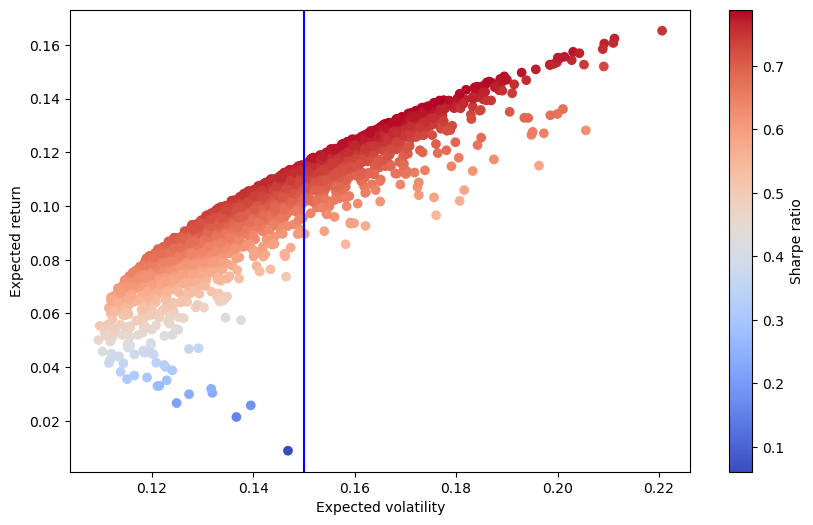

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=sharpe, marker='o', cmap='coolwarm')
plt.axvline(x = 0.15, color = 'blue', label = '40')
plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.colorbar(label='Sharpe ratio');

### Numerical optimization
The goal of the theory is to calculate the weights of the portfolio to achieve the maximum return with the lowest volatility. The constraints are that the sum of weights is 1.0. We choose the Sharpe ratio (SR) as the function to maximize since its maximum should be a value for which we have the maximum return with the lowest volatility. Instead of maximizing the Sharpe ratio we can minimize its negation.

We define the function to be minimized: the negation of the Sharpe ratio

In [21]:
def min_func_sharpe(weights):  
    return -port_ret(weights) / port_vol(weights)

and the constraint for the weight of the assets in the portfolio
$$\sum_i w_i - 1 = 0$$

In [23]:
constraints = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

We set the bounds for the value of the weights to be within (0, 1)

In [24]:
number_of_assets = len(symbols)
bounds = tuple((0, 1) for x in range(number_of_assets))

We set as the iinitial guess to start the optimization process a portfolio with equal weights

In [25]:
equal_weights = np.array(number_of_assets * [1. / number_of_assets,])  
equal_weights 

array([0.25, 0.25, 0.25, 0.25])

In [26]:
min_func_sharpe(equal_weights)

-0.729683392711007

We use the [SciPy minimize()](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html) method, based on the [*Sequential Least Square Programming (SLSQP)*](https://en.wikipedia.org/wiki/Sequential_quadratic_programming) algorithm, to find the minimum of the negation of the Sharpe ratio. The SLSQP algorithm consist of writing the Lagrangian of the function and the constraints using a linearr parameter for each constraint and then calculating the value of the parameters using the classic least square method.

In [28]:
%%time 
opts = sco.minimize(min_func_sharpe, 
                    equal_weights,
                    method='SLSQP', 
                    bounds=bounds,
                    constraints=constraints)  

CPU times: total: 109 ms
Wall time: 84 ms


The minimization method returns a list of values among which we have the optimal weights x, the value of the function given the weights

In [29]:
opts

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.7891296138971186
       x: [ 4.403e-01  1.705e-01  3.892e-01  0.000e+00]
     nit: 6
     jac: [-2.386e-05  8.337e-06  2.337e-05  3.694e-02]
    nfev: 30
    njev: 6

In [30]:
opts['x'].round(3)

array([0.44 , 0.171, 0.389, 0.   ])

We can calculate the optimal portfolio return 

In [31]:
port_ret(opts['x']).round(3)

0.139

its volatility

In [32]:
port_vol(opts['x']).round(3)

0.176

and the optimal (maximum) Sharpe ratio

In [33]:
port_ret(opts['x']) / port_vol(opts['x'])

0.7891296138971186

Another possible portfolio is one that has the minimum volatility. This portfolio might fit better for investors that are more risk averse. We use volatility as the function to be minimized instead of the Sharpe ratio with the same constraint and bounds.

In [34]:
optv = sco.minimize(port_vol, 
                    equal_weights,
                    method='SLSQP', 
                    bounds=bounds,
                    constraints=constraints)

In [35]:
optv

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.10942024449846979
       x: [ 2.168e-19  1.540e-03  5.391e-01  4.593e-01]
     nit: 8
     jac: [ 1.108e-01  1.101e-01  1.096e-01  1.092e-01]
    nfev: 41
    njev: 8

We have the new optimal weights

In [36]:
optv['x'].round(3)

array([0.   , 0.002, 0.539, 0.459])

The optimal volatility, lower than that for the Sharpe ratio

In [37]:
port_vol(optv['x']).round(3)

0.109

The optimal return for the new portfolio is lower than before as the less risky portfolio provides a smaller return

In [38]:
port_ret(optv['x']).round(3)

0.051

Finally the Sharpe ratio of the new optimal portfolio that is also lower than before.

In [39]:
port_ret(optv['x']) / port_vol(optv['x'])

0.4652051259174492

### Efficient frontier
Investors want to know what is the risk associated to a given target return. Therefore the target return is used as an additional constraint to the portfolio optimization problem. 

In [40]:
constraints = ({'type': 'eq', 'fun': lambda x:  port_ret(x) - target_ret},
                {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})  

In [41]:
bounds = tuple((0, 1) for x in weights)

We can look for the optimal weights for a portfolio that provides a set o given returns with the lowest volatility associated to each of them. In this way we build the so called "efficient frontier" on the returns/volatility scatter plot. We perform a number of optimizations to calculate the optimal volatilities corresponding to the set of target returns. The target returns and the volatilities that form the efficient frontier will be plotted in the returns/volatilities scatter plot. 

In [42]:
num_target_rets = 50

In [44]:
%%time
target_rets = np.linspace(0.05, 0.2, num_target_rets)
target_vols = []
for target_ret in target_rets:
    res = sco.minimize(port_vol, equal_weights, method='SLSQP', bounds=bounds, constraints=constraints)  
    target_vols.append(res['fun'])
target_vols = np.array(target_vols)

CPU times: total: 5.12 s
Wall time: 5.13 s


We plot the returns/volatilities scatter plot, the efficient frontier and the two pair (return, volatility) that we have calculated before, one using the Sharpe ratio (yellow star), and the other one using the volatility (red start).  

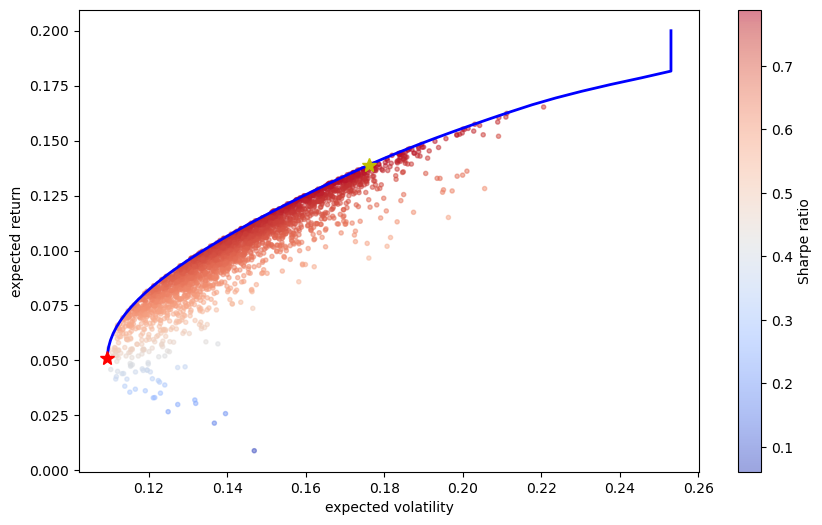

In [45]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols, marker='.', alpha=0.5, cmap='coolwarm') # returns/volatilities
plt.plot(target_vols, target_rets, 'b', lw=2.0)  # efficient frontier
plt.plot(port_vol(opts['x']), port_ret(opts['x']), 'y*', markersize=10.0)  # Sharpe ratio
plt.plot(port_vol(optv['x']), port_ret(optv['x']), 'r*', markersize=10.0)  # minimum volatility
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio');

### Capital market line
A portfolio is usually composed of a number of risky assets, such as stocks, and some riskless assets such as treasury bonds or cash. These assets, assumed as riskless, would lie on the vertical axis. A portfolio composed of the risky assets and the riskless ones should lie on the line r = a + bv that is tangent to the efficient frontier and that intersects the vertical axis at the value corresponding to the return of the riskless asset. In order to find the tangent of the efficient frontier at the point of the target volatility we have to calculate a function that approximates the efficient frontier and then calculate the first derivative at a given volatility value.

We start from the pair of minimum volatility

In [47]:
min_vol_index = np.argmin(target_vols)
min_vol_index

0

we remove from the data the last 6 values because those last volatilities are constant but the spline method requires a monotonically increasing function 

In [49]:
efficient_vols = target_vols[min_vol_index:-6]  
efficient_rets = target_rets[min_vol_index:-6] 

We use the [SciPy splrep()](https://docs.scipy.org/doc/scipy-1.16.2/reference/generated/scipy.interpolate.splrep.html) spline method to approximate the efficient frontier. The method returns a tuple of knots, B-spline coefficients, and the degree of the spline. This information is used to evaluate the function and its derivative.

In [50]:
tck = interpolate.splrep(efficient_vols, efficient_rets)

In [51]:
def f(x):
    ''' Efficient frontier function (splines approximation). '''
    return interpolate.splev(x, tck, der=0)
    
def df(x):
    ''' First derivative of efficient frontier function. '''
    return interpolate.splev(x, tck, der=1)

Once we have a functional form of the efficient frontier and of its first derivative we can determine the tangent line r = a + bv by solving a system of equations, that is   

a - f(x0) = 0  
a + bx - f(x) = 0  
b - f'(x) = 0  

where x0 is a first guess for the risk-free return

In [52]:
def equations(p, rf=0.01):
    eq1 = rf - p[0]  
    eq2 = rf + p[1] * p[2] - f(p[2])  
    eq3 = p[1] - df(p[2])  
    return eq1, eq2, eq3

In [53]:
opt = sco.fsolve(equations, [0.01, 0.5, 0.15])
opt

array([0.01      , 0.7332466 , 0.18214106])

In [54]:
np.round(equations(opt), 6)

array([0., 0., 0.])

We set the coefficients of the capital market line:  
*y = a + bx*

In [56]:
a = opt[0]
b = opt[1]

Finally we plot the efficient frontier with the tangent capital market line

Text(0.5, 1.0, 'Capital market line')

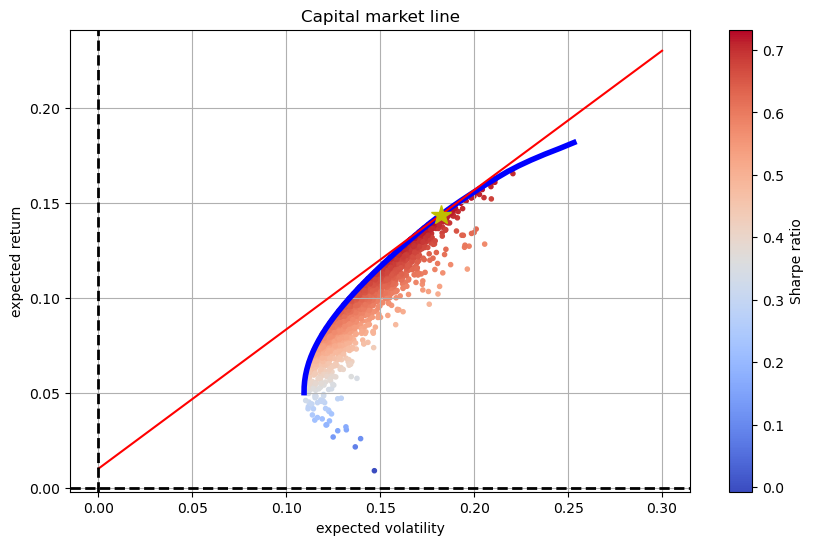

In [57]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=(prets - 0.01) / pvols, marker='.', cmap='coolwarm')
plt.plot(efficient_vols, efficient_rets, 'b', lw=4.0)
cx = np.linspace(0.0, 0.3)
plt.plot(cx, a + b * cx, 'r', lw=1.5)
plt.plot(opt[2], f(opt[2]), 'y*', markersize=15.0) 
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio');
plt.title('Capital market line')

In [58]:
cons = ({'type': 'eq', 'fun': lambda x:  port_ret(x) - f(opt[2])},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

In [59]:
res = sco.minimize(port_vol, 
                   equal_weights, 
                   method='SLSQP',
                   bounds=bounds, 
                   constraints=constraints)